In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import os

Using TensorFlow backend.


In [2]:
# These have to be exactly the same as the values used to extract the data.
offset = 360
n_fft=2**14
hop_length=2**12
sr = 48000

In [3]:
model = keras.models.load_model('modelBU.hdf5')

In [4]:
combinedDir = '/media/root/Ohne Titel/combined'
mask = np.load('featuremask.npy')
minval = np.load('minVal.npy')
scaleval = np.load('scaleFactorVal.npy')

def normalize(x):
    x = (x-minval)/scaleval
    return x


In [5]:
fullPaths = [os.path.join(combinedDir,x) for x in os.listdir(combinedDir)]
# fullPaths

In [6]:
allDict ={}
for j,aFile in enumerate(fullPaths):
    aName = os.listdir(combinedDir)[j]
    data = pd.read_csv(aFile,index_col=0,header=[0,1])

    x = data.drop(['label'], level=0,axis=1)

    nx = normalize(x)

    xreduced = np.array(nx)[:,mask.ravel()]

    N = len(nx)
    n = np.arange(N)
    times = librosa.core.frames_to_time(n,sr=sr,hop_length=hop_length,n_fft=n_fft)+offset
    predictions = np.zeros(N)
    for i in n:
        predictions[i] = model.predict(np.array([xreduced[i]]))
    allDict[aName]=predictions

In [7]:
# pd.DataFrame(allDict)

In [14]:
altTexts = ['normal operation 1', 
           'normal operation 2',
           'normal operation 3',
           'Lubricant Removed',
           'Loose Screw on Extruder Fan',
           'Low Hobbed Bolt Tension of Extruder']

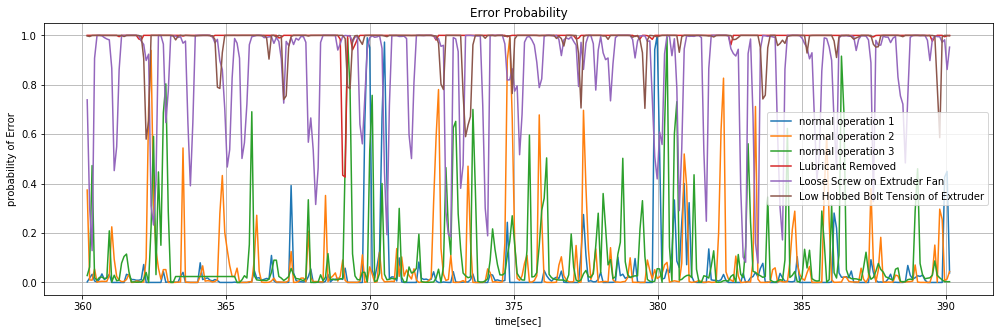

In [15]:
plt.figure(figsize=[17,5])
for i,key in enumerate(allDict.keys()):
    plt.plot(times,allDict[key], label=altTexts[i])
    df = pd.DataFrame([times,allDict[key]])
    df.to_csv(os.path.join('errorProbabilityCSVs/',key ))
plt.grid()
plt.legend()
plt.xlabel('time[sec]')
plt.ylabel('probability of Error')
plt.title('Error Probability')
plt.savefig('confidence')
plt.show()
